# InceptionV3 : Images - Iteration #5_1 : Without Data Augementation - LR Optimization 

img_rows = 299 <br>
img_cols = 299 <br>
batch_size = 64 <br>
epochs = 100 <br>
Train set size = 67933 <br>
Valid set size = 16983 <br>
Without Data augmentation <br>
Freeze layers of the Base model layers  <br>
Optimize LR with LearningRateScheduler <br>
Start with small LR: 0,00001 then increase the value evry  epoch until 2.54 <br>
then elect a learning rate that achieves the lowest loss <br>

**<u>Results</u>**

Accuracy : 0.?? <br>
F1 score weighted : 0.?? <br>

**Import packages**

In [21]:
import os
import glob
import pandas as pd
import numpy as np
import cv2
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import re
tqdm_notebook.pandas()
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score , recall_score, accuracy_score, precision_score, confusion_matrix
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn import metrics
import itertools
import pickle
from joblib import dump, load

# Iteration #5_1 - InceptionV3

***Read DataFrame from saved pickele file - image Train set***

In [2]:
#Load df of images already resized on 256 x 256 
#df_train_im = pd.read_pickle("./saves/df_save/df_train_combined_19102021.pkl")

#Load df of images with org size 500 x 500
df_train_im = pd.read_pickle("./saves/df_save/df_train_combined_ORG_im_size_02122021.pkl")

In [3]:
df_train_im.head()

,designation,description,productid,imageid,prdtypecode,imagePath
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10,image_1263597046_product_3804725264.jpg
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280,image_1008141237_product_436067568.jpg
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50,image_938777978_product_201115110.jpg
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280,image_457047496_product_50418756.jpg
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705,image_1077757786_product_278535884.jpg


In [4]:
display(df_train_im.shape)

(84916, 6)

***Create Dataframe containing  product classes and their associated labels***

In [5]:
#Dictionary of prdtypecode and their corresponding categories
dict_prdtypecode = {"prdtypecode" : [50, 2705, 2522, 2582, 1560, 1281, 1920, 1280, 1140, 1300, 2060, 2583,
                                     60, 1320, 2280, 1302, 2220, 40, 2905, 2585, 1940, 1160, 1301, 10, 1180,
                                     2403, 2462],                 
            
                    "Label" : ["video games accessories", "books", "stationery", "kitchen and garden", 
                               "interior furniture and bedding", "board games", "interior accessories",
                               "toys for children","goodies", "remote controlled models", "decoration interior",
                               "piscine spa","games and consoles", "early childhood", "magazines", "kids toys",
                               "supplies for domestic animals", "imported video games", "online distribution of video games",
                               "gardening and DIY","Food","playing cards", "accessories children", "adult books",
                               "figurines_wargames", "children books",
                                "games"]
                   }
df_class = pd.DataFrame(data=dict_prdtypecode)
df_class

,prdtypecode,Label
0,50,video games accessories
1,2705,books
2,2522,stationery
3,2582,kitchen and garden
4,1560,interior furniture and bedding
5,1281,board games
6,1920,interior accessories
7,1280,toys for children
8,1140,goodies
9,1300,remote controlled models


In [6]:
# Crate DF containing prdtypecode , categories and corresponding class used by model
df_class = df_class.sort_values(by = 'prdtypecode', ascending = True)
df_class['target_prdtypecode'] = [i for i in range(27)]
df_class

,prdtypecode,Label,target_prdtypecode
23,10,adult books,0
17,40,imported video games,1
0,50,video games accessories,2
12,60,games and consoles,3
8,1140,goodies,4
21,1160,playing cards,5
24,1180,figurines_wargames,6
7,1280,toys for children,7
5,1281,board games,8
9,1300,remote controlled models,9


***Change the 27 product codes to 0 to 26***

In [7]:
df_train_im.replace({'prdtypecode':{10:0,
                                    40:1,
                                    50:2,
                                    60:3,
                                    1140:4,
                                    1160:5,
                                    1180:6,
                                    1280:7,
                                    1281:8,
                                    1300:9                                    
                                    }}, inplace = True)

df_train_im.replace({'prdtypecode':{1301:10,
                                    1302:11,
                                    1320:12,
                                    1560:13,
                                    1920:14,
                                    1940:15,
                                    2060:16,
                                    2220:17,
                                    2280:18,
                                    2403:19,
                                    2462:20,
                                    2522:21,
                                    2582:22,
                                    2583:23,
                                    2585:24,
                                    2705:25,
                                    2905:26
                                    }}, inplace = True)

In [8]:
display(df_train_im["prdtypecode"].unique())

array([ 0, 18,  2,  7, 25, 21, 22, 13,  8, 14, 19,  4, 23,  6,  9, 20,  5,
       16,  1,  3, 12, 11, 17, 26, 24, 15, 10], dtype=int64)

 ***Convert product code to string type***

In [9]:
df_train_im["prdtypecode"] = df_train_im["prdtypecode"].astype(str)

In [10]:
unique, counts = np.unique(df_train_im["prdtypecode"], return_counts=True)
dict(zip(unique, counts))

{'0': 3116,
 '1': 2508,
 '10': 807,
 '11': 2491,
 '12': 3241,
 '13': 5073,
 '14': 4303,
 '15': 803,
 '16': 4993,
 '17': 824,
 '18': 4760,
 '19': 4774,
 '2': 1681,
 '20': 1421,
 '21': 4989,
 '22': 2589,
 '23': 10209,
 '24': 2496,
 '25': 2761,
 '26': 872,
 '3': 832,
 '4': 2671,
 '5': 3953,
 '6': 764,
 '7': 4870,
 '8': 2070,
 '9': 5045}

 ***Split Train Set***

In [ ]:
# Split Train set 
# X_train_im, X_test_im = train_test_split(df_train_im, train_size=0.8, random_state=1234)

In [ ]:
#display(X_train_im.shape)
#display(X_test_im.shape)

***Data Generator***

In [11]:
img_rows = 299
img_cols = 299
batch_size = 64
epochs = 100

# Directory of images already resized on 256 x 256 
#images_dir_train = './data/images/all/image_train_resized/'
#images_dir_train = 'E:/WorkSpace_DataScience_E/Rakuten_Projet_Local/My_WS/data/images/all/image_train_resized/'

# Directory of images org resize 500 x 500
images_dir_train = './data/images/all/image_train/'
#images_dir_train = 'E:/WorkSpace_DataScience_E/Rakuten_Projet_Local/My_WS/data/images/all/image_train/'

In [12]:
%%time
#Générateur de données
img_gen = ImageDataGenerator(rescale = 1/255, 
                             validation_split = 0.2)

Wall time: 0 ns


In [13]:
%%time

#Itérateur 
train_generator = img_gen.flow_from_dataframe(dataframe = df_train_im,
                                              directory = images_dir_train,
                                              as_ext = True,
                                              x_col = 'imagePath',
                                              y_col = 'prdtypecode',  #target data                                            
                                              class_mode = 'sparse',                                             
                                              target_size = (img_rows , img_cols), # default 256 x 256                                             
                                              batch_size = batch_size,                                             
                                              shuffle = True, # défault
                                              subset = 'training'
                                             )

Found 67933 validated image filenames belonging to 27 classes.
Wall time: 3.49 s


In [15]:
%%time
# validation_split the validation batches ca be retrieved by specifying the subset as validation.
valid_generator = img_gen.flow_from_dataframe(dataframe = df_train_im, 
                                              directory = images_dir_train,
                                              as_ext = True,
                                              x_col = 'imagePath',
                                              y_col = 'prdtypecode',  #target data                                            
                                              class_mode = 'sparse',                                        
                                              target_size = (img_rows , img_cols), # default 256 x 256                                         
                                              batch_size = batch_size, 
                                              shuffle = False,
                                              subset  = 'validation'
                                             )

Found 16983 validated image filenames belonging to 27 classes.
Wall time: 3.21 s


 ***InceptionV3 Implementation***

In [17]:
%%time
# Chargement du modèle InceptionV3
inceptionV3  = InceptionV3(weights='imagenet', include_top = False, input_shape=(img_rows,img_rows,3))

# Bloquage du blackbone
for layer in inceptionV3.layers:
    layer.trainable = False
    
model = Sequential()
model.add(inceptionV3)
# Ajout des couche de classification
model.add(GlobalAveragePooling2D()) 
model.add(Dense(units = 1024,activation='relu'))

model.add(Dropout(rate = 0.2))
model.add(Dense(units = 512, activation='relu'))

model.add(Dropout(rate = 0.2))
#model.add(Dense(units = 27, activation='softmax'))
model.add(Dense(units = 27, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 27)               

 ***Compilation***

In [18]:
%%time
# Compilation
model.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer= Adam(learning_rate= 1e-5) ,   #default lr = 0.001 # algorithme de descente de gradient
              metrics=['accuracy'])                    # métrique d'évaluation

Wall time: 18 ms


***Callbacks***

In [19]:
def increasinglrUpdate(epoch, learning_rate):
    if epoch ==0:
        print("[INFO] : Starting : epoch: ", epoch , "learning_rate : ", learning_rate)
        return learning_rate
    else:
        lr_updated = 1e-5 * 100 ** (epoch / 37)
        print("[INFO] : Learning rate updated from:", learning_rate, 'to: ',  lr_updated)
        return lr_updated

In [22]:
%%time
path = './saves/InceptionV3/Iteration_5_1/'
file_name = 'checkpoint_InceptionV3_09012022_Shape-299x299_100Epochs.h5'

#Sauvegarder les meilleurs poids du modèle au cours de l'entraînement :
checkpoint = ModelCheckpoint(filepath = path + file_name , 
                             monitor ='val_accuracy',                            
                             save_best_only = True, # (pour que le meilleur modèle ne soit pas écrasé)
                             save_weights_only = False,
                             mode ='max', #(permet de préciser si la métrique doit croître ou décroitre : ici on choisit 'min'
                                           #car la métrique est une perte à minimiser)
                             save_freq='epoch',
                             verbose = 1
                             )
#Arrêter l'entraînement si le modèle n'évolue plus (très pratique pour ne pas gérer le
#nombre d'epoch) :
early = EarlyStopping(monitor='val_loss',
                      min_delta = 0.01, # si au bout de 5 epochs la fonction de perte ne varie pas de 1%, 
                                         # que ce soit à la hausse ou à la baisse, on arrête
                      patience = 5, #(nombre d'epochs à attendre avant d'arrêter l'entraînement
                      restore_best_weights = True,                     
                      mode = 'min',
                      verbose = 1,
                      )
#ReduceLROnPlateau. Lorsque qu'une métrique ne s'améliore plus d'une epoch à l'autre, 
#on peut diminuer le taux d'apprentissage (*Learning Rate*) pour y remédier. 
#Pour définir les critères et les conditions de réduction de taux d'apprentissage, 
#on peut utiliser les paramètres suivants : 

lr_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                               patience = 3,  #si val_loss stagne sur 3 epochs consécutives selon la valeur epsilon                            
                               mode='min',
                               min_delta = 0.01, # Si val loss n'a pas varié de 1 % on applique 
                               factor = 0.1,  # On réduit le learning rate d'un facteur 0.1 ( On divise le LR par 10)
                               cooldown = 4, # On attend 4 epochs avant de réitérer.
                                             #Nombre d'epochs de 'pause' entre deux mesures de suivis du *learning rate*.
                               verbose=1
                               )


lrScheduler = LearningRateScheduler(schedule = increasinglrUpdate, verbose = 1)
#lrScheduler = LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 37)
#We’ll train the model for 100 epochs to test 100 different loss/learning rate combinations.
#Here’s the range for the learning rate values: 1e-5 * 100 ** (0 / 37) and 1e-5 * 100 ** (100 / 37)
# (1e-05, 2.543345761304648)

Wall time: 0 ns


 ***Fit - train_generator***

In [23]:
step_size_Train = train_generator.n//train_generator.batch_size
step_size_Valid = valid_generator.n//valid_generator.batch_size
print('step_size_Train : ' , step_size_Train)
print('step_size_Valid  : ' , step_size_Valid)

step_size_Train :  1061
step_size_Valid  :  265


In [24]:
%%time
# Fit Train generator
history = model.fit(train_generator,                    
                    epochs = epochs,                   
                    steps_per_epoch = step_size_Train,
                    validation_data = valid_generator,
                    validation_steps = step_size_Valid,
                    #callbacks=[checkpoint, early, lr_plateau]
                    callbacks=[lrScheduler]                    
                    )

Epoch 1/100
[INFO] : Starting : epoch:  0 learning_rate :  9.999999747378752e-06

Epoch 00001: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
1061/1061 [==============================] - 454s 416ms/step - loss: 2.5125 - accuracy: 0.3066 - val_loss: 2.0071 - val_accuracy: 0.4386
Epoch 2/100
[INFO] : Learning rate updated from: 9.999999747378752e-06 to:  1.132541315152812e-05

Epoch 00002: LearningRateScheduler setting learning rate to 1.132541315152812e-05.
1061/1061 [==============================] - 367s 346ms/step - loss: 1.9726 - accuracy: 0.4340 - val_loss: 1.7754 - val_accuracy: 0.4850
Epoch 3/100
[INFO] : Learning rate updated from: 1.1325412742735352e-05 to:  1.2826498305280606e-05

Epoch 00003: LearningRateScheduler setting learning rate to 1.2826498305280606e-05.
1061/1061 [==============================] - 362s 341ms/step - loss: 1.8021 - accuracy: 0.4755 - val_loss: 1.6750 - val_accuracy: 0.5075
Epoch 4/100
[INFO] : Learning rate updated from: 1.282649

1061/1061 [==============================] - 348s 328ms/step - loss: 1.7432 - accuracy: 0.4955 - val_loss: 1.7065 - val_accuracy: 0.4996
Epoch 53/100
[INFO] : Learning rate updated from: 0.005711586680263281 to:  0.0064686076615463285

Epoch 00053: LearningRateScheduler setting learning rate to 0.0064686076615463285.
1061/1061 [==============================] - 348s 328ms/step - loss: 1.8162 - accuracy: 0.4761 - val_loss: 1.7388 - val_accuracy: 0.5006
Epoch 54/100
[INFO] : Learning rate updated from: 0.0064686075784265995 to:  0.007325965428215231

Epoch 00054: LearningRateScheduler setting learning rate to 0.007325965428215231.
1061/1061 [==============================] - 350s 329ms/step - loss: 1.8568 - accuracy: 0.4667 - val_loss: 1.7457 - val_accuracy: 0.4912
Epoch 55/100
[INFO] : Learning rate updated from: 0.007325965445488691 to:  0.008296958520834907

Epoch 00055: LearningRateScheduler setting learning rate to 0.008296958520834907.
1061/1061 [==============================] - 3

***Save History results***

In [25]:
# Save History results
path = './saves/InceptionV3/Iteration_5_1/'
filename = 'history_InceptionV3_all_train_09012022_Shape-299x299_100Epochs'

In [26]:
#convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# history to json:  
hist_json_file = path + filename + '.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# history to csv: 
hist_csv_file = path + filename +'.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# history to pickle file
hist_df.to_pickle(path + filename +'.pkl')

***Display Model loss , accuracy per epoch***

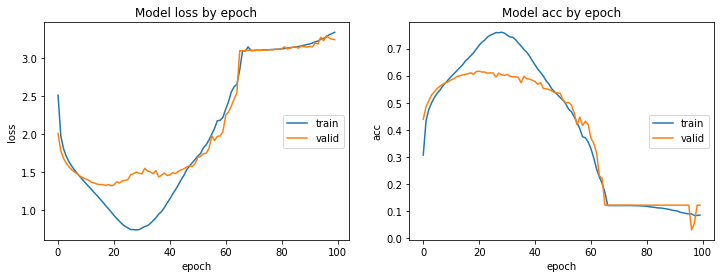

In [27]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

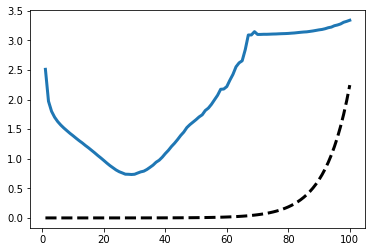

In [28]:
plt.plot(
    np.arange(1, 101), 
    history.history['lr'], 
    label='Learning rate', color='#000', lw=3, linestyle='--')

plt.plot(
    np.arange(1, 101), 
    history.history['loss'], 
    label='Loss', lw=3
)

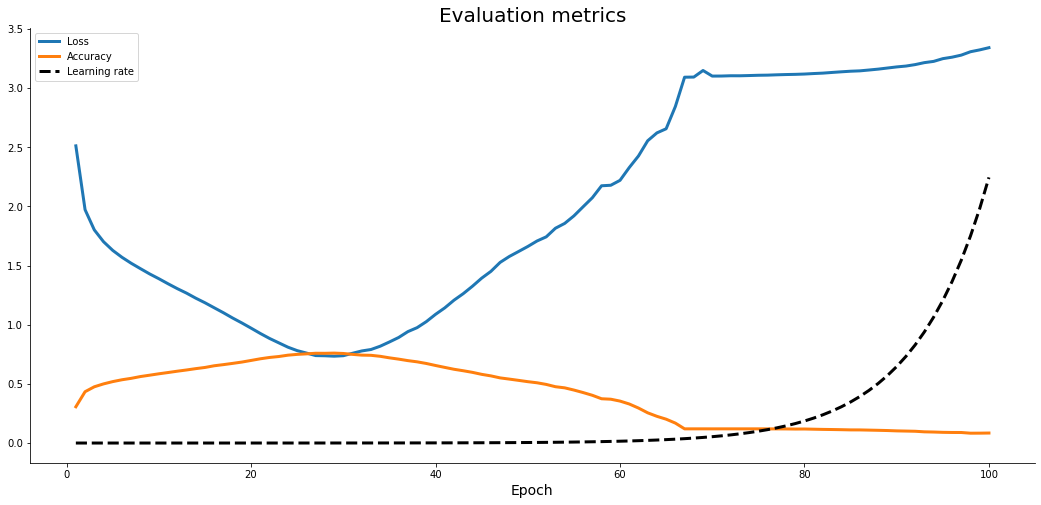

In [29]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False 

plt.plot(
    np.arange(1, 101), 
    history.history['loss'], 
    label='Loss', lw=3
)
plt.plot(
    np.arange(1, 101), 
    history.history['accuracy'], 
    label='Accuracy', lw=3
)
plt.plot(
    np.arange(1, 101), 
    history.history['lr'], 
    label='Learning rate', color='#000', lw=3, linestyle='--'
)
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

In [ ]:
"""
L'accuracy augmente lègèrement jusqu'à l'Epoch 28 
avant de commencer à baisser jusqu'à l'Epoch 66
Ensuite s'est pratiquement aplatie juqu'à la fin de training 


L'exact opposé est arrivé à la Loss jusqu'à l'Epoch 66 ( Ce qui est logique)
ensuite se stablise jusqu'à la fin de training

"""

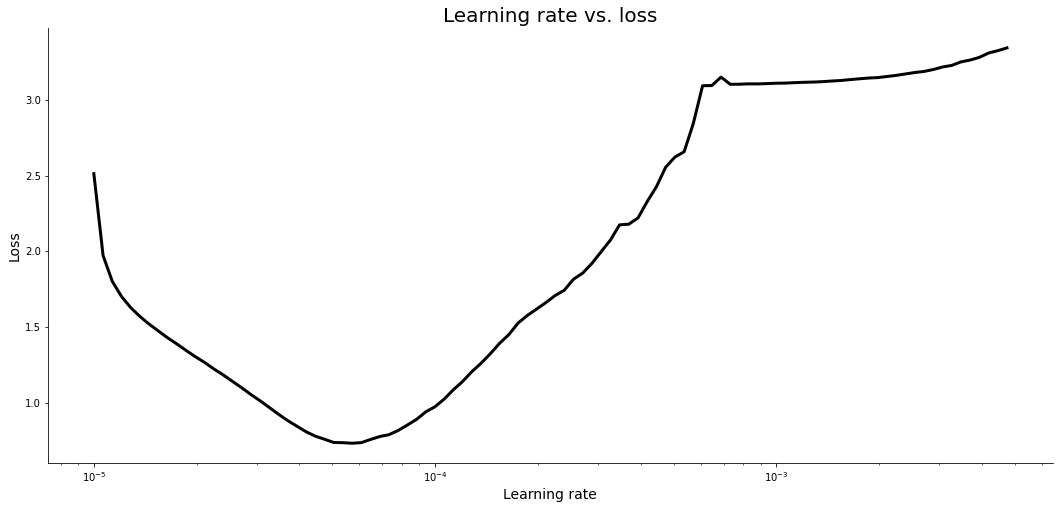

In [30]:
#1e-5 * 10 ** (epoch / 37)
learning_rates = 1e-5 * (10 ** (np.arange(100) / 37))
plt.semilogx(
    learning_rates, 
    history.history['loss'], 
    lw=3, color='#000'
)
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14);

In [ ]:
"""
Nous voulons sélectionner un taux d'apprentissage 
qui réalise la perte la plus faible, à condition que les valeurs 
qui l'entourent ne soient pas trop volatiles. 
Le taux d'apprentissage optimal (avec la plus faible perte) est aux alentout de 0.0003 :
"""

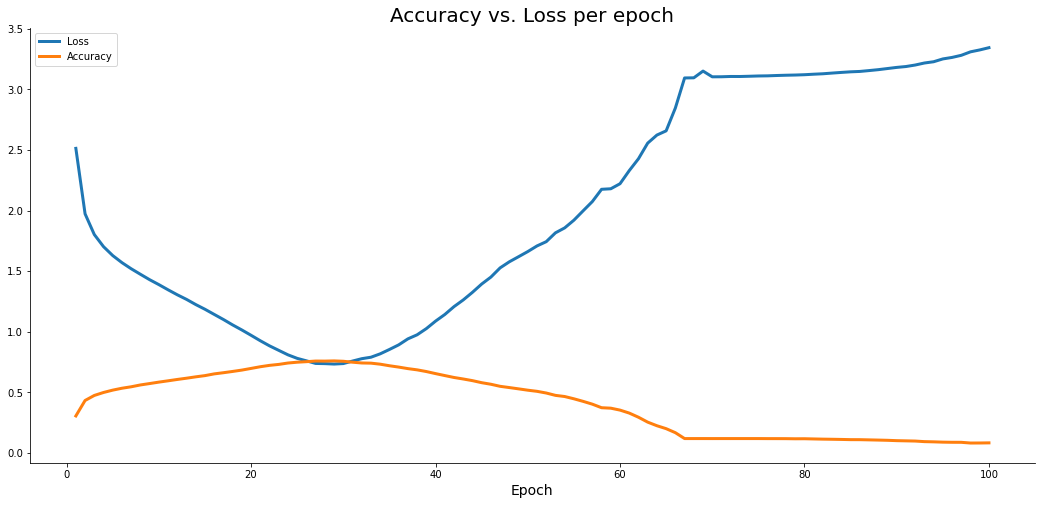

In [31]:
plt.plot(
    np.arange(1, 101), 
    history.history['loss'], 
    label='Loss', lw=3
)
plt.plot(
    np.arange(1, 101), 
    history.history['accuracy'], 
    label='Accuracy', lw=3
)
plt.title('Accuracy vs. Loss per epoch', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()

 ***Prediction - test_generator***

In [32]:
%%time
#Prediction - Valid set
y_pred_proba = model.predict(valid_generator)

# l'argmax pour obtenir les classes prédites
y_pred_class = np.argmax(y_pred_proba,axis = 1).astype(int)

# To get classes from test generator
y_true = valid_generator.classes

Wall time: 1min 10s


 ***Evaluation - test_generator***

In [33]:
%%time
#Get the accuracy score
valid_score = model.evaluate(valid_generator)
print("[INFO] Model metrics names:", model.metrics_names)
print("[INFO] Accuracy: {:.2f}%".format(valid_score[1] * 100)) 
print("[INFO] Loss: ",valid_score[0])

266/266 [==============================] - 70s 263ms/step - loss: 3.2457 - accuracy: 0.1214
[INFO] Model metrics names: ['loss', 'accuracy']
[INFO] Accuracy: 12.14%
[INFO] Loss:  3.2457029819488525
Wall time: 1min 10s


In [34]:
f1_macro = f1_score(y_true, y_pred_class, average='macro')
print("[INFO] f1 score macro average: ",f1_macro)

f1_micro = f1_score(y_true, y_pred_class, average='micro')
print("[INFO] f1 score micro average: ",f1_micro)

f1_weighted = f1_score(y_true, y_pred_class, average='weighted')
print("[INFO] f1 score weighted average: ",f1_weighted)

[INFO] f1 score macro average:  0.008016523139396485
[INFO] f1 score micro average:  0.12135665076841548
[INFO] f1 score weighted average:  0.026267176773125848


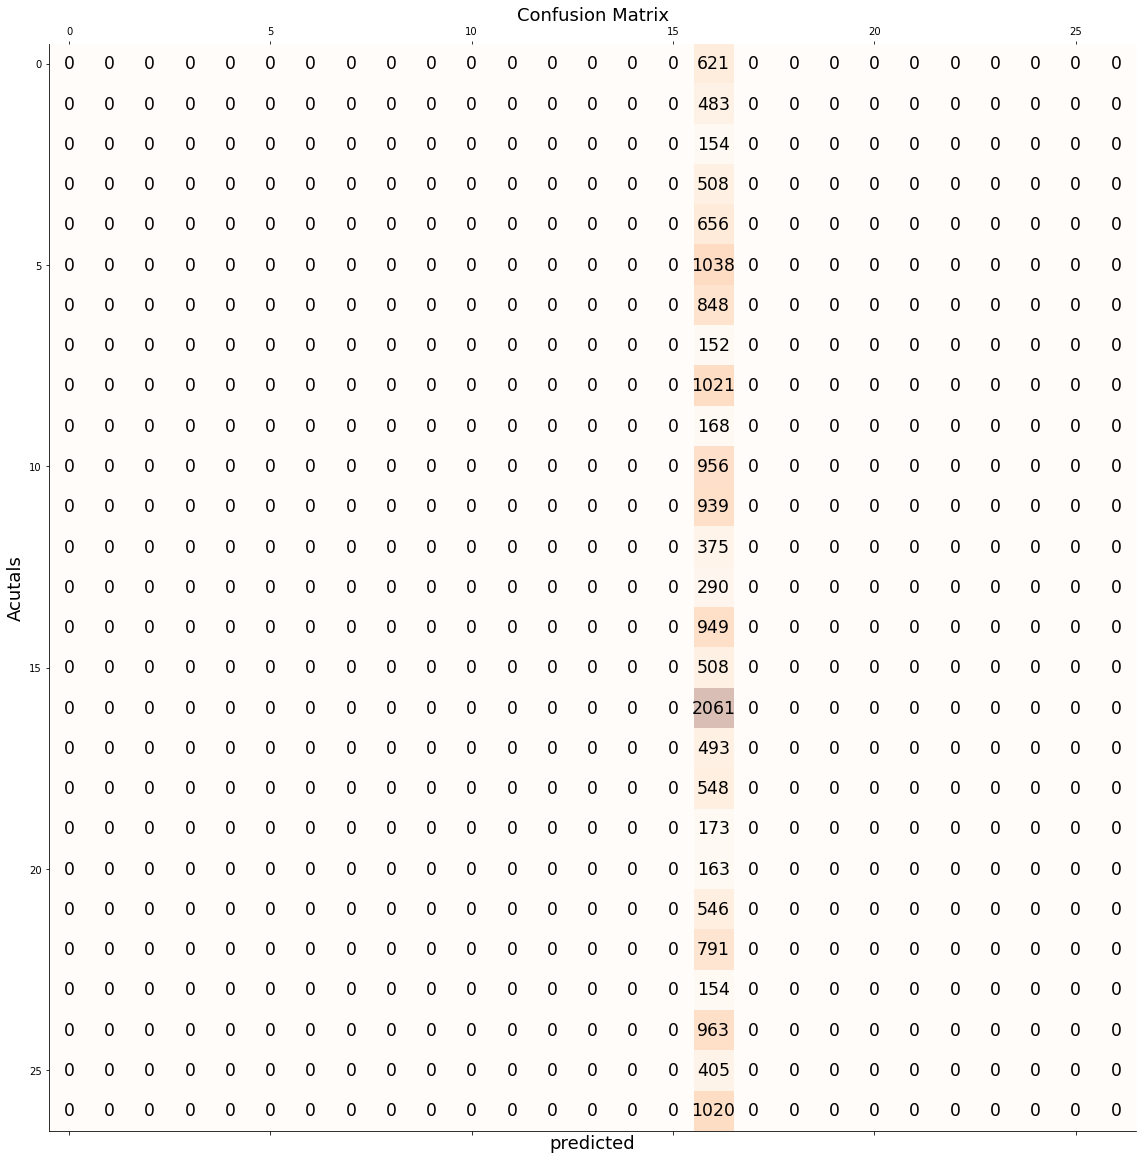

In [35]:
#Confusion matrix
matrix = confusion_matrix(y_true, y_pred_class)
fig , ax = plt.subplots(figsize = (24,20))
ax.matshow(matrix, cmap = plt.cm.Oranges , alpha = 0.3)
for i in range(matrix.shape[0]):
    for j in range (matrix.shape[1]):
        ax.text (x = j , y= i, s= matrix[i,j], va = 'center', ha = 'center', size = 'xx-large')
        
plt.xlabel('predicted', fontsize = 18)
plt.ylabel('Acutals', fontsize = 18)
plt.title('Confusion Matrix', fontsize = 18)
plt.show()
#print(matrix)

In [36]:
print(metrics.classification_report(y_true, y_pred_class))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       621
           1       0.00      0.00      0.00       483
           2       0.00      0.00      0.00       154
           3       0.00      0.00      0.00       508
           4       0.00      0.00      0.00       656
           5       0.00      0.00      0.00      1038
           6       0.00      0.00      0.00       848
           7       0.00      0.00      0.00       152
           8       0.00      0.00      0.00      1021
           9       0.00      0.00      0.00       168
          10       0.00      0.00      0.00       956
          11       0.00      0.00      0.00       939
          12       0.00      0.00      0.00       375
          13       0.00      0.00      0.00       290
          14       0.00      0.00      0.00       949
          15       0.00      0.00      0.00       508
          16       0.12      1.00      0.22      2061
          17       0.00    

C:\Users\MME\anaconda3\envs\datascientestEnv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MME\anaconda3\envs\datascientestEnv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MME\anaconda3\envs\datascientestEnv\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

 ***Predict input image using trained model***

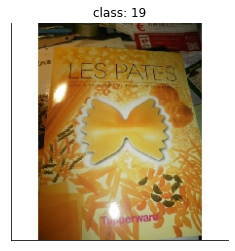

In [37]:
# Predict With Pre Trained

# Load an image
im_id = 255
#img_path ='./data/images/all/image_train_resized/'+ df_train_im['imagePath'][im_id]
img_path ='./data/images/all/image_train/'+ df_train_im['imagePath'][im_id]

img = image.load_img(img_path,target_size=(224, 224))
plt.figure(figsize=(6,4))
plt.imshow(img)
plt.title("class: " + str(df_train_im['prdtypecode'][im_id]))
plt.xticks([])
plt.yticks([])
#plt.axis('off')
plt.show();

In [ ]:
im = cv2.resize(cv2.imread(img_path), (299, 299))
im = np.expand_dims(im, axis=0)

In [ ]:
out = model.predict(im)
print("------------------Predicted Class and Label ------------------------------")
print("target class(used by model) :", np.argmax(out))
print("\n"  ,df_class[df_class['target_prdtypecode'] == np.argmax(out)][['prdtypecode', 'Label']].to_string(index=False)) 

prd_code = df_train_im['prdtypecode'][im_id]

print("\n\n------------------Real Class and Label ------------------------------")
print("target class(used by model): " ,  df_class[df_class['target_prdtypecode'] == int(prd_code)]['target_prdtypecode'].to_string(index=False))
print("\n"  ,df_class[df_class['target_prdtypecode'] == int(prd_code)][['prdtypecode', 'Label']].to_string(index=False)) 


 


 ***Save InceptionV3 Model***

In [38]:
#Enregistrement du modèle
model.save("./saves/InceptionV3/Iteration_5_1/Model_InceptionV3_All_train_data_09012022_Shape-299x299_100Epochs.hdf5")
#The SavedModel and HDF5 file contains:
#the model's configuration (topology)
#the model's weights
#the model's optimizer's state (if any)

 ***Load DenseNet121 Model***

In [ ]:
#Rechargement du modèle :
model = load_model("./saves/InceptionV3/Iteration_5_1/Model_InceptionV3_All_train_data_09012022_Shape-299x299_100Epochs.hdf5")